In [1]:
import queue
import pandas as pd
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

INPUTS

In [2]:
# a parede é um cubo/quadrado determinado pelo tamanho do lado do cubo/quadrado e numero de dimensoes
tamanho_parede: float      = 10
numero_dimensoes: int      = 2
quantidade_particulas: int = 10

raio:  float = 1
massa: float = 1

velocidade_maxima: float = 100

PARTICULAS

- Classe das particulas

In [3]:
class Particula:
    def __init__(self, raio: float, massa: float, vetor_posicao: list[float], vetor_velocidade: list[float]) -> None:
        self.massa = float(massa)
        self.raio  = float(raio)
        self.vetor_posicao    = np.array(vetor_posicao, dtype= np.float64)
        self.vetor_velocidade = np.array(vetor_velocidade, dtype= np.float64)

    @property
    def momento(self) -> npt.NDArray[np.float64]:
        """Retorna um ndarray dado por: massa * velocidade"""
        return self.massa * self.vetor_velocidade
    
    @property
    def energia_cinetica(self) -> np.float64:
        """Retorna um float64 dado por: massa * <velocidade, velocidade>"""
        return self.massa * np.vdot(self.vetor_velocidade, self.vetor_velocidade)
    
    def atualizar_posicao(self, tempo_decorrido: float) -> None:
        """Usa a equação horária do movimento da partícula para atualizar sua posição um delta_t"""
        self.vetor_posicao += self.vetor_velocidade * tempo_decorrido
    
    def reflexao(self, dimensao_reflexão: int) -> None:
        """
        Edita o vetor velocidade, invertendo o sentido da velocidade na dimensão dada, como uma colisão elástica com a parede.

        Parameters
        ----------
        dimensao_reflexao : int
            0 - Inverte o sentido da velocidade em x\n
            1 - Inverte o sentido da velocidade em y\n
            2 - Inverte o sentido da velocidade em z
        """
        self.vetor_velocidade[dimensao_reflexão] = -self.vetor_velocidade[dimensao_reflexão]

    def __str__(self) -> str:
        return "Raio {}, massa {}, posicao {} e velocidade {}".format(self.raio, self.massa, self.vetor_posicao, self.vetor_velocidade)
    
    def __repr__(self) -> str:
        return "Particula({}, {}, {}, {})".format(self.raio, self.massa, self.vetor_posicao.tolist(), self.vetor_velocidade.tolist())

- RNG
- Criador de vetor aleatorio (com dimensoes certas e sem zeros)

In [4]:
# o RNG é um gerador aleatorio de float64 entre [0, 1)
rng = np.random.default_rng()

def vetor_aleatorio(valor_minimo: float, valor_maximo: float, dimensoes: int) -> npt.NDArray[np.float64]:
    """
    Gera um vetor (ndarray[float64]) com as dimensões dadas, com valores entre valor_minimo e valor_maximo, não inclusivo. Isso é para não ter problemas como iniciar na posição 0 (em colisão com parede)
    
    Returns
    -------
    vetor_aleatorio: ndarray[float64]
        Um vetor de dimensões dadas entre valor_minimo e valor_maximo, não inclusivo.
    """
    vetor_zero_a_um = rng.random(dimensoes)
    
    while min(vetor_zero_a_um) == 0:
        vetor_zero_a_um[vetor_zero_a_um == 0] = rng.random() # remapeia valores nulos, se tiver
    
    vetor_aleatorio = (valor_maximo - valor_minimo) * vetor_zero_a_um + valor_minimo

    return vetor_aleatorio

CRIADOR DE LISTA DE PARTICULAS

- Calculador de momento total de uma lista de particulas

In [5]:
def momento_total_lista(lista_de_particulas: list[Particula]) -> npt.NDArray[np.float64]:
    """Soma os vetores de momento de todas as partículas em uma lista"""
    momento_total = np.zeros(numero_dimensoes)
    
    for particula in lista_de_particulas:
        momento_total += particula.momento
        
    return momento_total

- Criador de partículas
- Criador da lista de partículas

In [6]:
# criador de particula com posicao e velocidade aleatorias
def criar_particula_aleatoria(raio: float, massa: float) -> Particula:
    """
    Returns
    -------
    particula_criada: Particula
        Uma partícula com raio e massa dados pelo usuário e a posição e a velocidade aleatorizadas (distribuição uniforme)
    """
    posicao_minima    = 0 + raio
    posicao_maxima    = tamanho_parede - raio
    velocidade_minima = - velocidade_maxima # velocidades podem ser positivas ou negativas

    posicao_criada    = vetor_aleatorio(posicao_minima, posicao_maxima, numero_dimensoes)
    velocidade_criada = vetor_aleatorio(velocidade_minima, velocidade_maxima, numero_dimensoes)

    particula_criada = Particula(raio, massa, posicao_criada, velocidade_criada)
    return particula_criada


# criador da lista de partículas
def criar_particulas_iniciais(quantidade_particulas: int, raio: float, massa: float) -> list[Particula]: 
    """Usa a função criar_particula_aleatoria para criar a uma lista com a quantidade de partículas desejada, ajustando a última para que o momento total da lista seja zero"""
    # primeiro monta uma lista inicial das particulas
    lista_particulas = [criar_particula_aleatoria(raio, massa) for i in range(quantidade_particulas)]

    # depois calculamos o momento total das particulas (exceto a ultima)
    momento_total = momento_total_lista(lista_particulas[:-1])
    
    # e calculamos as velocidades da ultima particula para o momento total ser zero 
    ultima_particula = lista_particulas[-1]
    velocidade_ultima_particula = - momento_total / ultima_particula.massa
    ultima_particula.vetor_velocidade = velocidade_ultima_particula

    return lista_particulas
        

FUNÇÕES DAS COLISÕES
- Cálculo do vetor normal
- Cálculo das velocidades
- Atualização das velocidades

In [7]:
def vetor_normal_colisao(particula_1: Particula, particula_2: Particula) -> npt.NDArray[np.float64]:
    """
    Não usar fora da colisão!\n
    Na colisão, a magnetude do vetor distância é a soma dos raios, simplificando o cálculo do vetor normal.\n
    
    Returns
    -------
    vetor_normal: ndarray[float64]
        Nota: o vetor gerado aponta para a fora da superfície da particula_1!\n
        normal = vetor_distancia / (soma_dos_raios)
    """
    posicao_1 = particula_1.vetor_posicao
    posicao_2 = particula_2.vetor_posicao

    raio_1 = particula_1.raio
    raio_2 = particula_2.raio
    
    vetor_distancia = posicao_2 - posicao_1
    modulo_vetor_distancia = raio_1 + raio_2
    
    vetor_normal = vetor_distancia / modulo_vetor_distancia

    return vetor_normal

In [ ]:
def velocidades_apos_colisao(massas: list[float], velocidades_normais: list[np.float64]) -> list[np.float64]:
    """
    No momento da colisão, podemos decompor as velocidades das partículas em suas componentes normal ao impacto (v1 e v2) e tangencial. Somente a velocidade normal é alterada.\n
    v1_nova = ( (m1 - m2) v1 -   2 m2    v2 ) / (m1 + m2)\n
    v2_nova = (   2 m1    v1 - (m1 - m2) v2 ) / (m1 + m2)

    Returns
    -------
    lista_velocidades_novas: list[float64]
        É uma lista formada pelas velocidades normais novas calculadas, na forma  [v1_nova, v2_nova]
    """
    m1, m2 = massas
    v1, v2 = velocidades_normais
    
    diff_massa = m1 - m2
    soma_massa = m1 + m2

    velocidade_1_nova = (diff_massa * v1 -    2*m2    * v2) / soma_massa
    velocidade_2_nova = (   2*m1    * v1 - diff_massa * v2) / soma_massa

    return [velocidade_1_nova, velocidade_2_nova]

In [9]:
def colisao(particula_1: Particula, particula_2: Particula) -> None: # O(1)
    """
    Atualiza as velocidades das partículas durante uma colisão. Usar somente se a colisão já for confirmada.\n
    Para mudar a velocidade normal sem alterar a velocidade tangencial, o vetor da velocidade tangencial é calculado e somado com a velocidade normal nova:\n\n
    velocidade_normal     = <velocidade_antes, vetor_normal>\n
    velocidade_tangencial = velocidade_antes - velocidade_normal\n

    velocidade_antes  = velocidade_tangencial + velocidade_normal\n
    velocidade_depois = velocidade_tangencial + velocidade_normal_nova
    """
    vetor_normal = vetor_normal_colisao(particula_1, particula_2)

    massa_1 = particula_1.massa
    massa_2 = particula_2.massa

    v1_normal = np.vdot(particula_1.vetor_velocidade, vetor_normal)
    v2_normal = np.vdot(particula_2.vetor_velocidade, vetor_normal)

    vetor_v1_tangente = particula_1.vetor_velocidade - v1_normal * vetor_normal
    vetor_v2_tangente = particula_2.vetor_velocidade - v2_normal * vetor_normal

    v1_normal_novo, v2_normal_novo = velocidades_apos_colisao(massas = [massa_1, massa_2], velocidades_normais = [v1_normal, v2_normal])
    
    particula_1.vetor_velocidade = vetor_v1_tangente + v1_normal_novo * vetor_normal
    particula_2.vetor_velocidade = vetor_v2_tangente + v2_normal_novo * vetor_normal

PREVISÃO DE COLISÕES
- Colisão entre duas particulas (colocar somente se a colisao ja tiver sido confirmada pfv)
- Colisão contra paredes

In [10]:
numero_muito_grande = np.float64(0b111_111_111_111_111) # um valor muito grande para retornar se não for possível colisões

def tempo_colisao_particulas(particula_1: Particula, particula_2: Particula) -> np.float64: # O(1)
    """
    Calcula o tempo para duas partículas se colidirem (a velocidades constantes) ou um valor bem grande, para não interferir na lista.\n
    Nota: Se as partículas estiverem dentro uma da outra, retorna resultado negativo. Tomar cuidado com isso nas primeiras colisões\n
    Podemos imaginar que a distância relativa é um vetor que cresce no sentido da velocidade relativa. Nesse caso, uma colisão seria o momento delta_t que faz a distância relativa ter magnetude igual à soma dos raios das partículas

    Returns
    -------
    tempo_para_colisao: float64
        O tempo para que ocorra a colisão entre as duas partículas.
    
    numero_muito_grande: float64
        Caso não ocorra colisão, retorna um valor muito grande (2^15 - 1) para ser ignorado na lista de prioriade (variável global).
    """
    raio_1 = particula_1.raio
    raio_2 = particula_2.raio
    distancia_colisao = raio_1 + raio_2

    posicao_1 = particula_1.vetor_posicao
    posicao_2 = particula_2.vetor_posicao
    delta_r   = posicao_1 - posicao_2
    
    velocidade_1 = particula_1.vetor_velocidade
    velocidade_2 = particula_2.vetor_velocidade
    delta_v      = velocidade_1 - velocidade_2

    produto_v_r  = np.vdot(delta_r, delta_v)

    if produto_v_r >= 0: # Se a distancia relativa estiver aumentando, elas estão se afastando
        return numero_muito_grande

    delta_v_quadrado = np.vdot(delta_v, delta_v)
    delta_r_quadrado = np.vdot(delta_r, delta_r)

    discriminante = produto_v_r * produto_v_r - delta_v_quadrado * (delta_r_quadrado - distancia_colisao * distancia_colisao)

    if discriminante < 0: # se o discriminante de baskara for menor que zero, nao ha colisão
        return numero_muito_grande
    
    else: # se tiver tudo certo pra colisao, calcula o tempo de colisao normalmente
        tempo_colisao = - (produto_v_r + np.sqrt(discriminante)) / delta_v_quadrado
        return tempo_colisao

In [ ]:
def tempo_colisao_paredes(particula: Particula) -> npt.NDArray[np.float64]: # O(1)
    """
    Nota: Depende das variáveis globais numero_dimensoes para calcular as colisões em cada dimensão. Não entrar particulas com vetores de dimensões diferentes.\n
    Calcula o tempo para que a particula colida com uma parede, já levando em consideração o sentido da velocidade. Se não for possível uma colisão com a parede na dimensão checada, retorna um valor muito grande, para ser ignorado na lista de colisões.
    
    Returns
    -------
    tempos_colisao: NDArray[float64]
        Lista formada pelos tempos para a partícula colidir com a parede daquela dimensão (0 = x, 1 = y, 2 = z)

    tempo_para_colisao: float64
        O tempo para que ocorra a colisão entre as duas partículas.
    
    numero_muito_grande: float64
        Caso não ocorra colisão, retorna um valor muito grande (2^15 - 1) para ser ignorado na lista de prioriade.
    """
    tempos_colisoes = []

    posicao    = particula.vetor_posicao
    velocidade = particula.vetor_velocidade
    raio       = particula.raio
    
    for i in range(numero_dimensoes):
        if velocidade[i] > 0:
            distancia = (tamanho_parede - posicao[i] - raio)
            tempo_calculado = distancia / velocidade[i]
        
        elif velocidade[i] < 0:
            distancia = (raio - posicao[i])
            tempo_calculado = distancia / velocidade[i]

        else: # Se a velocidade for zero, a partícula não tem como atingir nenhuma das duas paredes.
            tempo_calculado = numero_muito_grande

        tempos_colisoes.append(tempo_calculado)
    
    return tempos_colisoes

LISTA DE PRIORIDADE
- Gerar pares de colisões
- Calcular a posição de todos os pares com a particula de indice N na lista

In [12]:
def gerar_pares_colisoes(quantidade_particulas: int) -> list[list[int]]: # O(n^2)
    """
    Gera as combinações das possíveis condições de colisão de duas particulas, representadas como números de 0 a quantidade_particulas - 1 na lista.\n

    Example
    -------
    >>> gerar_pares_colisoes(4)
    [[0, 1], [0, 2], [0, 3], [0, 4], [1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [3, 4]]

    >>> # Uma forma melhor de visualizar o resultado seria como tabela:
        # [
        # [0, 1], [0, 2], [0, 3], [0, 4],
        #         [1, 2], [1, 3], [1, 4],
        #                 [2, 3], [2, 4],
        #                         [3, 4]
        # ]
    """
    pares_colisoes = []

    for i in range(0, quantidade_particulas):
        for j in range(i+1, quantidade_particulas):
            pares_colisoes.append([i,j])
    
    return pares_colisoes

In [13]:
def gerar_colisoes_paredes(quantidade_particulas: int, numero_dimensoes: int) -> list[list[int]]: # O(n)
    indices_paredes    = np.arange(-1, -(numero_dimensoes + 1), -1)
    indices_particulas = np.arange(quantidade_particulas)
    
    colisoes_paredes = []
    for indice_parede in indices_paredes:
        for indice_particula in indices_particulas:
            colisoes_paredes.append([indice_particula, indice_parede])

    return colisoes_paredes

In [14]:
def numero_primeira_posicao(numero_desejado: int, quantidade_particulas: int) -> int:
    """
    Com os pares de colisões sendo uma lista ordenada da forma que seu output ordena naturalmente, o numero_desejado passa a se repetir na primeira posição nos pares a partir de uma posição. Essa função calcula a posição em que essa repetição começa.\n
    Nota: Retorna valores iguais ou maiores que o tamanho da lista de pares se o numero não aparecer na primeira posição.
    
    Example
    -------
    >>> gerar_pares_colisoes(4)
    [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]
    >>> len(gerar_pares_colisoes(4))
    6
    >>> numero_primeira_posicao(1, 4)
    3
    >>> numero_primeira_posicao(2, 4)
    5
    >>> numero_primeira_posicao(3, 4) # nao existe na lista, retorna um numero maior ou igual ao tamanho da lista
    6
    
    Derivação
    ---------
    Podemos considerar que a posição que o numero N aparece na primeira posição é igual à posição que N-1 aparece na primeira posição dos pares + a quantidade de vezes que N-1 permanece na primeira posição:\n
        posicao(N) = posicao(N-1) + repeticao(N-1)

    E como o valor N é contado uma vez para cada número menor que N, restam somente (valor_maximo - N) combinações com o número N ao chegar na primeira posição:\n
        repeticao(N) = (valor_maximo - N)

    Com isso, podemos usar a recursão dessa função para descobrir sua fórmula, lembrando que o valor 0 aparece na primeira posição da lista de combinações (posição 0 em python):\n
        posicao(N) = posicao(N-1) + repeticao(N-1)
        posicao(N) = posicao(N-2) + repeticao(N-2) + repeticao(N-1)
        ...
        posicao(N) = posicao(0) + repeticao(0) + repeticao(1) + ... + repeticao(N-2) + repeticao(N-1)
        posicao(0) = 0
        posicao(N) = repeticao(0) + repeticao(1) + ... + repeticao(N-2) + repeticao(N-1)

    E aplicando a formula para o calculo da repeticao temos o seguinte padrão:\n
        posicao(N) = valor_maximo + (valor_maximo - 1) + (valor_maximo - 2) + ... + (valor_maximo - (N-2)) + (valor_maximo - (N-1))
        posicao(N) = N * valor_maximo - (1 + 2 + ... + (N-2) + (N-1))
        posicao(N) = N * valor_maximo - N * (N-1)/2

    E lembrando que começa-se a contar do 0, valor_maximo vale quantidade_particulas - 1:\n
        posicao(N) = N * (quantidade_particulas - 1) - N * (N-1)/2
        posicao(N) = N * (quantidade_particulas - 1 - (N-1)/2)
        posicao(N) = N * (quantidade_particulas - (N+1)/2)
    """
    posicao_repeticao = int(numero_desejado * (quantidade_particulas - (numero_desejado + 1) / 2))
    return posicao_repeticao

In [15]:
def indices_lista_de_pares(numero_desejado: int, quantidade_particulas: int) -> list[int]: # tecnicamente O(n), mas basicamente O(1) para nosso uso
    """
    Essa função calcula todas as posições em que o numero_desejado aparece na lista gerar_pares_colisoes(quantidade_particulas), seja na primeira posição da dupla ou na segunda.
    
    Example
    -------
    >>> gerar_pares_colisoes(4)
    [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]
    >>> posicoes_lista_de_pares(1, 4)
    [0, 3, 4]
    >>> posicoes_lista_de_pares(3, 4)
    [2, 4, 5]
    """
    inicio_primeiro_lugar: int     = numero_primeira_posicao(numero_desejado, quantidade_particulas)
    quantidade_primeiro_lugar: int = quantidade_particulas - numero_desejado - 1 # O numero se repete (valor_maximo - numero_desejado) vezes
    
    # quando no primeiro lugar da dupla, o numero aparece em todas as posicoes de inicio_primeiro_lugar ate inicio_primeiro_lugar + quantidade_primeiro_lugar
    indices_primeiro_lugar: list[int] = [i for i in range(inicio_primeiro_lugar, inicio_primeiro_lugar + quantidade_primeiro_lugar)]

    # quando aparece no segundo lugar, ele o primeiro numero é menor que ele, aparecendo sempre numero_desejado - i - 1 posicoes depois de i assumir o primeiro lugar da dupla
    indices_segundo_lugar:  list[int] = [numero_primeira_posicao(i, quantidade_particulas) + numero_desejado - i - 1 for i in range(numero_desejado)]

    return indices_segundo_lugar + indices_primeiro_lugar

CHECAGEM DE POSSIBILIDADE DAS COLISOES

In [ ]:
def checar_tempo_colisao(tempo_calculado: np.float64) -> bool:
    resultado_checagem = tempo_calculado > 0 and tempo_calculado < numero_muito_grande
    return resultado_checagem

def checar_colisao_particulas(particula_1: Particula, particula_2: Particula, tolerancia: float) -> bool:
    posicao_1 = particula_1.vetor_posicao
    posicao_2 = particula_2.vetor_posicao
    raio_1 = particula_1.raio
    raio_2 = particula_2.raio

    distancia_colisao = raio_1 + raio_2 + tolerancia
    distancia_quadrada_colisao = distancia_colisao * distancia_colisao

    vetor_distancia_centros = posicao_2 - posicao_1
    distancia_quadrada = np.vdot(vetor_distancia_centros, vetor_distancia_centros)

    resultado_checagem = distancia_quadrada <= distancia_quadrada_colisao
    return resultado_checagem

def checar_colisao_parede(particula: Particula, dimensao_parede: int, tolerancia: float) -> bool:
    vetor_posicao       = particula.vetor_posicao
    posicao_na_dimensao = vetor_posicao[dimensao_parede]
    distancia_colisao   = particula.raio + tolerancia

    resultado_checagem  = posicao_na_dimensao < distancia_colisao
    return resultado_checagem

LISTA DE PRIORIDADE

In [17]:
q = queue.PriorityQueue()
q.put((1, [1,2]))

In [ ]:
def criar_fila_prioridade(lista_particulas: list[Particula]) -> list[np.float64 | int]: # O(n^2)
    """
    Cria a fila de eventos para as colisoes, retornando uma lista de elementos (tempo de colisão e índice das partículas ou paredes na colisão) organizados pelo menor tempo de colisão. Os eventos são organizados no seguinte formato:\n
        evento = [tempo_colisao, indice_particula, indice_particula_ou_parede]
    Nota: As paredes usam índices negativos, calculados pela formula -(numero_da_dimensão + 1), para não se confundirem com os índices das partículas:\n
        -1: Parede em x\n
        -2: Parede em y\n
        -3: Parede em z
    """
    fila_eventos = []
    pares_colisoes = gerar_pares_colisoes(len(lista_particulas))

    # Primeiro calcula os eventos para as colisões das particulas
    for indices_par in pares_colisoes:
        particula_1 = lista_particulas[indices_par[0]]
        particula_2 = lista_particulas[indices_par[1]]

        # checa se as particulas nao tao uma dentro da outra, dentro de uma tolerancia
        estao_em_colisao = checar_colisao_particulas(particula_1, particula_2, 0.01 * particula_1.raio)

        if estao_em_colisao:
            tempo_calculado_particulas = numero_muito_grande # se tiverem, ignorar a colisao
        else:
            tempo_calculado_particulas = tempo_colisao_particulas(particula_1, particula_2)

        # so adiciona o evento se representar uma colisao possivel (tempo positivo e menor que numero_muito_grande) para simplificar o uso da lista no futuro
        colisao_eh_possivel = checar_tempo_colisao(tempo_calculado_particulas)
        if colisao_eh_possivel:
            evento = [tempo_calculado_particulas] + indices_par
            fila_eventos.append(evento)
    
    # depois para cada parede, lembrando que a função resolve para as tres paredes
    for indice_particula in range(len(lista_particulas)):
        particula = lista_particulas[indice_particula]
        tempos_calculados_paredes = tempo_colisao_paredes(particula)

        for dimensao in range(numero_dimensoes):
            indice_parede = - (dimensao + 1)
            
            # nao precisa checar o tempo, a probabilidade de nao ser possivel colidir com uma parede é muito pequena
            evento = [tempos_calculados_paredes[dimensao]] + [indice_particula, indice_parede]
            fila_eventos.append(evento)

    fila_eventos.sort(key=lambda item: item[0])

    return fila_eventos

In [19]:
def adicionar_na_fila(fila: list, tempo_calculado: np.float64, indices: list[int]) -> int:
    """
    Essa função edita a lista da fila de prioridade para adicionar a colisão calculada na fila já na ordem certa. Retorna 0 ao concluir.
    
    Example
    -------
    >>> fila_prioridade = [[1, [0,1]], [2, [1, 3]]]
    >>> adicionar_na_fila(fila_prioridade, 0, [0,2])
    >>> adicionar_na_fila(fila_prioridade, 1.5, [0,3])
    >>> fila_prioridade
    [[0, 0, 2], [1, 0, 1], [1.5, 0, 3]], [2, 1, 3]]
    """
    lista_tempos = [colisao[0] for colisao in fila]

    maior_posicao = len(lista_tempos) - 1
    menor_posicao = 0

    menor_tempo = lista_tempos[menor_posicao]
    maior_tempo = lista_tempos[maior_posicao]

    if tempo_calculado <= menor_tempo: # O(1)
        fila.insert(0, [tempo_calculado, indices])
        return 0
    
    if tempo_calculado >= maior_tempo: # O(1)
        fila.append([tempo_calculado, indices])
        return 0
    
    while maior_tempo - menor_tempo > 1: # O(log n)
        posicao_meio = np.floor((menor_posicao + maior_posicao) / 2) # checar se é um int
        tempo_meio = lista_tempos[posicao_meio]

        if tempo_calculado > tempo_meio: # checar se é maior ou maior igual
            menor_posicao = posicao_meio
            menor_tempo = tempo_meio
        
        else:
            maior_posicao = posicao_meio
            maior_tempo = posicao_meio
    
    posicao_insert = maior_posicao
    fila.insert(posicao_insert, [tempo_calculado, indices])
    return 0

TESTAGEM

In [20]:
from time import perf_counter
import scipy as sci

In [21]:
def tamanho_ponto_particula(diametro: float): # formula empirica para ajustar o tamanho das particulas no grafico
    return 67000 / 100 * diametro * diametro

def plotar_particulas(lista_de_particulas: list[Particula]):
    diametros  = []
    posicoes_x = []
    posicoes_y = []
    posicoes_z = []
    for i in lista_de_particulas:
        diametros.append(2 * i.raio)
        posicoes_x.append(i.vetor_posicao[0])
        posicoes_y.append(i.vetor_posicao[1])
        # posicoes_z.append(i.vetor_posicao[2])

    fig = plt.figure()
    ax = fig.add_subplot()

    ax.scatter(posicoes_x, posicoes_y, s = [tamanho_ponto_particula(d) for d in diametros])
    ax.set_aspect(1)
    ax.set_xlim(-0.01 * tamanho_parede, 1.01 * tamanho_parede)
    ax.set_ylim(-0.01 * tamanho_parede, 1.01 * tamanho_parede)
    return ax

In [22]:
tempos = []
quantidades = []

In [23]:
qtd = 1000 * 7

# populacao = criar_particulas_iniciais(qtd,1,2)

for i in range(qtd):
    particula_aleatoria = criar_particula_aleatoria(np.pi,np.e)
    particula_em_colisao = Particula(1, 2, particula_aleatoria.vetor_posicao + [(np.pi + 1) * np.sqrt(2)/2, (np.pi + 1) * np.sqrt(2)/2], [-1, -1])
    comeco = perf_counter()
    colisao(particula_aleatoria,particula_em_colisao)
    fim = perf_counter()
    
    tempos.append(fim - comeco)
quantidades.append(qtd)

quantidades = [i for i in range(1, qtd + 1)]


In [24]:
particula_aleatoria = criar_particula_aleatoria(np.pi,np.e)
particula_em_colisao = Particula(1, 2, particula_aleatoria.vetor_posicao + [(np.pi + 1) * np.sqrt(2)/2, (np.pi + 1) * np.sqrt(2)/2], [-1, -1])

checar_colisao_particulas(particula_aleatoria, particula_em_colisao, 1e-15)
# plotar_particulas([particula_aleatoria, particula_em_colisao])

True

In [25]:
def quadratica(x, a, b, c): return a + b * x + c * x * x

# a, b, c = sci.optimize.curve_fit(quadratica, quantidades, tempos)[0]

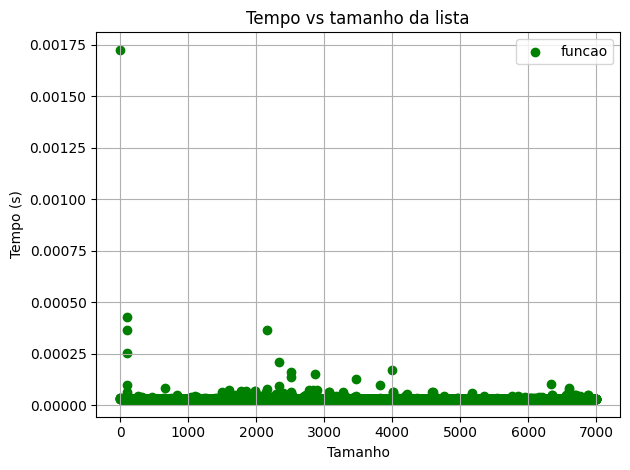

In [26]:
x = np.arange(min(quantidades), max(quantidades), 1)

# plt.plot(x, quadratica(x,a,b,c),
#          color="r", linestyle="--", label="regressao quadratica")

plt.scatter(quantidades, tempos,
         color="g", label="funcao")


plt.title("Tempo vs tamanho da lista")
plt.xlabel("Tamanho")
plt.ylabel("Tempo (s)")

plt.grid(True)

plt.legend()

plt.tight_layout() #for padding issues

plt.show()

In [27]:
teste1 = Particula(raio=1, massa=2, vetor_posicao=[0,0], vetor_velocidade=[1,1])
teste2 = Particula(raio=1, massa=2, vetor_posicao=[5,0], vetor_velocidade=[0,0])

tempo_colisao_particulas(teste1,teste2)

32767.0

In [28]:
angulo = 32 #°
teste1 = Particula(raio=1, massa=2, vetor_posicao=[0,0,0], vetor_velocidade=[5 * np.cos(angulo * np.pi/180), 5 * np.sin(angulo * np.pi/180), 0])
teste2 = Particula(raio=1, massa=2, vetor_posicao=[2 * np.cos(angulo * np.pi/180), 2 * np.sin(angulo * np.pi/180), 0], vetor_velocidade=[0,0,0])

print(teste1.vetor_velocidade, teste2.vetor_velocidade)
colisao(teste1, teste2)
print(teste1.vetor_velocidade, teste2.vetor_velocidade)

[4.24024048 2.64959632 0.        ] [0. 0. 0.]
[8.8817842e-16 4.4408921e-16 0.0000000e+00] [4.24024048 2.64959632 0.        ]


In [29]:
populacao = criar_particulas_iniciais(quantidade_particulas=200, raio=0.01, massa=1)

<Axes: >

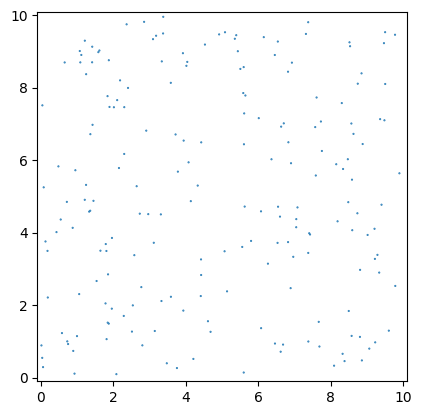

In [30]:
plotar_particulas(populacao)